In [4]:
import numpy as np
import pandas as pd
import sweetviz as sv
import seaborn           as sns
import matplotlib.pyplot as plt
import shap

from xgboost                 import XGBClassifier

from sklearn.compose         import ColumnTransformer
from sklearn.impute          import SimpleImputer
from sklearn.metrics         import make_scorer, accuracy_score, f1_score, balanced_accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler , RobustScaler


import inflection

ModuleNotFoundError: No module named 'shap'

In [2]:
!pip install shap


  Using cached shap-0.42.1-cp39-cp39-win_amd64.whl (462 kB)
  Using cached numba-0.57.1-cp39-cp39-win_amd64.whl (2.5 MB)
  Using cached cloudpickle-2.2.1-py3-none-any.whl (25 kB)
  Using cached llvmlite-0.40.1-cp39-cp39-win_amd64.whl (27.7 MB)
  Using cached numpy-1.24.4-cp39-cp39-win_amd64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.1
    Uninstalling numpy-1.25.1:
      Successfully uninstalled numpy-1.25.1


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Viviane\\AppData\\Local\\pypoetry\\Cache\\virtualenvs\\hack-5-SadZoKWp-py3.9\\Lib\\site-packages\\~~mpy\\.libs\\libopenblas64__v0.3.23-gcc_10_3_0.dll'
Check the permissions.


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
def rename_columns(dataframe):
    df = dataframe.copy()
    title = lambda x: inflection.titleize(x)
    snakecase = lambda x: inflection.underscore(x)
    accent = lambda x: inflection.transliterate(x)
    spaces = lambda x: x.replace(" ", "")
    cols_old = list(df.columns)
    cols_old = list(map(title, cols_old))
    cols_old = list(map(spaces, cols_old))
    cols_old = list(map(accent, cols_old))
    cols_new = list(map(snakecase, cols_old))
    df.columns = cols_new
    return df



In [12]:
# Dados de Treino
df_train      = pd.read_csv('base\\train.csv')
df_raw        = pd.read_csv('base\\train.csv')

# Dados de Teste
df_test       = pd.read_csv('base\\test.csv')

# # Modelo de Submissão
df_submission = pd.read_csv('base\\submission.csv')

In [13]:
df_train = rename_columns(df_train)
df_test = rename_columns(df_test)

In [14]:
df_raw.columns

Index(['id', 'Gender', 'Customer Type', 'Age', 'Type of Purchase',
       'Store size', 'Store distance', 'InStore wifi',
       'Open/Close time convenient', 'Easy of online shopping',
       'Store location', 'Toilet cleaning', 'Dressing room', 'Waiting room',
       'Kids entertainment', 'Seller service', 'Showroom ', 'Self-Store',
       'Purchase service', 'Store Service', 'Cleanliness',
       'Carrier delay in minutes', 'Delivery delay in minutes',
       'Satisfaction'],
      dtype='object')

In [15]:
le = LabelEncoder()

df_train['satisfaction'] = le.fit_transform( df_train['satisfaction'] )

In [16]:
df_train['carrier_delay_in_minutes'] = np.log1p(df_train['carrier_delay_in_minutes'])
df_train['delivery_delay_in_minutes'] = np.log1p(df_train['delivery_delay_in_minutes'])
df_train['store_distance'] = np.log1p(df_train['store_distance'])



df_train['grupo1'] = df_train['in_store_wifi'] + df_train['self_store'] + df_train['store_service'] + df_train['purchase_service'] + df_train['seller_service'] + df_train['kids_entertainment'] + df_train['store_location']
df_train['grupo2'] = df_train['open/close_time_convenient'] + df_train['dressing_room'] + df_train['waiting_room']
df_train['grupo3'] = df_train['cleanliness'] + df_train['toilet_cleaning'] + df_train['waiting_room']


bins = [0, 18, 35, 50, float('inf')]  # Faixas etárias
labels = ['1', '2', '3', '4']  # Rótulos para cada faixa etária
df_train['age_category'] = pd.cut(df_train['age'], bins=bins, labels=labels)

In [20]:
import shap 
aux = pd.concat([df_raw['Satisfaction'],df_raw.drop(['Satisfaction'], axis=1)], axis=1)
# aux = df5.copy()
mask = np.zeros_like(aux.corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(36, 32))

plt.title('Pearson Correlation Matrix',fontsize=14, fontweight='bold')

sns.heatmap(aux.corr(method='spearman'), linewidths=0.25,fmt=".2f", cmap="Blues", linecolor='w',annot=True,annot_kws={"size":9},mask=mask,cbar_kws={"shrink": .9});

ModuleNotFoundError: No module named 'shap'

In [21]:
# Separação das variáveis independentes e dependente
X = df_train.drop(['satisfaction','id', 'gender', 'age'], axis=1)
y = df_train['satisfaction'].copy()

# Separação entre treino(75%) e teste(25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [22]:
# variáveis categóricas
cat_columns = list(X.select_dtypes(include=['object']).columns)

# variáveis numéricas
num_columns  = list(X.select_dtypes(include=['int64', 'float64']).columns)

In [23]:
# pipeline variáveis cateǵoricas
cat_pipe = Pipeline([("cat_imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                     ("ohe"        , OneHotEncoder(handle_unknown="ignore"))])

# pipeline variáveis numéricas
num_pipe = Pipeline([("num_imputer", SimpleImputer(missing_values=np.nan, strategy="median")),
                     ("outliers"   , RobustScaler()),
                     ("scaler"     , StandardScaler())])

# data preparation
preprocessing = ColumnTransformer([("categorica", cat_pipe, cat_columns),
                                   ("numerica", num_pipe, num_columns)])

In [24]:
# pipeline para treinamento
pipe = Pipeline([("preprocessing", preprocessing),
                 ("xgb", XGBClassifier())])

# Treino

In [25]:
# hiperparâmetros
xgb_hyperparams = {"xgb__max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15 ],
                   "xgb__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ], 
                   "xgb__min_child_weight" : [ 1, 3, 5, 7 ],
                   "xgb__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
                   "xgb__learning_rate"    : [ 0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] }

# métricas
f1_macro          = make_scorer(f1_score, average="macro")
precision         = make_scorer(precision_score)
recall            = make_scorer(recall_score)
accuracy          = make_scorer(accuracy_score)

scoring_dict = {'f1_macro'          : f1_macro,
                'precision'         : precision,
                'recall'            : recall,
                'accuracy'          : accuracy}

In [26]:
# Randomized Scearch Cross Validation
rscv = RandomizedSearchCV(estimator=pipe,
                          param_distributions=xgb_hyperparams,
                          n_iter = 10,
                          scoring = scoring_dict,
                          refit = 'precision',
                          n_jobs = -1,
                          cv = 5,
                          random_state=42)

In [27]:
# Resultado considerando a métrica principal (precision)
result = rscv.fit(X_train, y_train)

print(f'Os melhores parâmetros foram:\n{result.best_params_}')

print(f'\nA melhor média de precision foi: {result.best_score_}')

In [ ]:
# Pipeline do melhor resultado
result.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorica',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['customer_type',
                                                   'type_of_purchase',
                                                   'store_size']),
                                                 ('numerica',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outlier

In [ ]:
# Resultado com todas as métricas observadas
df_result = pd.DataFrame(result.cv_results_)

# Selecionando apenas algumas das colunas
df_result[['rank_test_f1_macro',
           'mean_test_f1_macro',
           'std_test_f1_macro',
           'mean_test_precision',
           'std_test_precision',
           'mean_test_recall',
           'std_test_recall',
           'mean_test_accuracy',
           'std_test_accuracy']].sort_values('rank_test_f1_macro').head()

,rank_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,mean_test_accuracy,std_test_accuracy
7,1,0.960833,0.002184,0.972171,0.002724,0.938386,0.002541,0.961708,0.002135
9,2,0.960755,0.001750,0.970746,0.001873,0.939631,0.002571,0.961618,0.001707
6,3,0.959784,0.001848,0.967119,0.001201,0.941054,0.003232,0.960643,0.001797
1,4,0.959687,0.001925,0.969978,0.001510,0.937941,0.002973,0.960579,0.001874
3,5,0.958519,0.001676,0.967396,0.000529,0.937852,0.003539,0.959424,0.001621


In [ ]:
# Treino com o melhor pipeline
pipe = result.best_estimator_
model = pipe.fit(X_train, y_train)

# Predição para dados nunca vistos
y_hat = model.predict(X_test)

# Métrica para dados não vistos pelo modelo
print(f'O f1-score foi: {f1_score(y_test, y_hat)}')
print(f'A precisão foi: {precision_score(y_test, y_hat)}')
print(f'O recall  foi:  {recall_score(y_test, y_hat)}')
print(f'A acurácia foi: {accuracy_score(y_test, y_hat)}')

O f1-score foi: 0.9534328089077222
A precisão foi: 0.9716097023153253
O recall  foi:  0.9359235330560226
A acurácia foi: 0.960232522328303


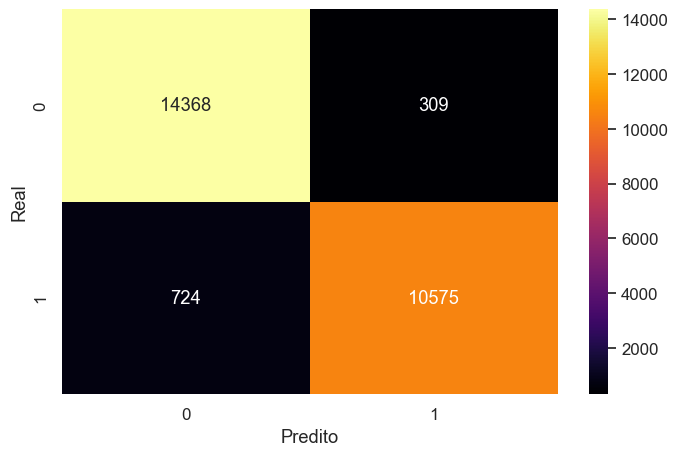

In [ ]:
# Matriz de Confusão
cnf_matrix = confusion_matrix(y_test, y_hat)
df_cm = pd.DataFrame(cnf_matrix, columns=np.unique(y_test), index=np.unique(y_test))
df_cm.index.name = 'Real'
df_cm.columns.name = 'Predito'
plt.figure(figsize = (8, 5))
sns.set(font_scale=1.1)
sns.heatmap(df_cm, cbar=True, cmap = 'inferno', annot = True, fmt='.0f');

# Retreino para submissão

In [32]:
# Retreino com o Pipeline do melhor resultado
pipe = result.best_estimator_
model = pipe.fit(X, y)

# predição
y_pred = model.predict(df_test)

KeyError: "['grupo1', 'grupo2', 'grupo3'] not in index"

In [ ]:
# atribuição da predição para coluna 'Reserva Cancelada' da submissão
df_submission['Satisfaction'] = y_pred

# Salva o df_submission em .csv
df_submission.to_csv('submission5.csv', index=False)